In [2]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import seaborn as sns
import numpy as np
#from tqdm import tqdm_notebook as tqdm
import os 
import re
import pandas as pd
import glob
from PIL import Image
import re
from IPython.display import display
os.chdir('/nfs/nhome/live/michaela/Documents/projects/MMD-GAN/')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def set_lim(xlims = None, ylims= None):
    if not xlims is None:
        plt.xlim(xlims[0], xlims[1])
    if not ylims is None:
        plt.ylim(ylims[0], ylims[1])
    #plt.axis('off')

In [5]:
def fig(xlims = None, ylims = None, num_subplots = None):
    x_size = 5
    y_size = 5
    if num_subplots is None:
        f = plt.figure(figsize=(x_size, y_size))
        ax = None
    else:
        f,ax = plt.subplots(num_subplots[0], num_subplots[1],figsize=(num_subplots[1]*y_size, num_subplots[0]*x_size))
    #set_lim(xlims, ylims)
    return f, ax

In [6]:
def plot_scores(ax, dirname, color = 'r', legend = '', ylims = None , N_max = 200000, N_min = 0, kid_only = False, decay =False):
    
    
    fnames = [ os.path.join(dirname, fname) for fname in os.listdir(dirname) if fname.endswith('.npz')  ]
    scores = np.zeros([3, len(fnames)])
    std_scores = np.zeros([3, len(fnames)])
    indices = np.zeros(len(fnames))

    for i, fname in enumerate(fnames):
        data = np.load(fnames[i]) 
        indices[i] = int(fname.split('/')[-1].split('score')[-1].split('.npz')[0])
        if kid_only:
            scores[2,i] = np.mean(data['mmd2'])
            scores[0,i] = np.mean(data['mmd2'])
            scores[1,i] = np.mean(data['mmd2'])
            std_scores[2,i] = np.std(data['mmd2'])
            std_scores[0,i] = np.std(data['mmd2'])
            std_scores[1,i] = np.std(data['mmd2'])
        else:
            scores[0,i] = np.mean(data['inception'])
            scores[1,i] = np.mean(data['fid'])
            scores[2,i] = np.mean(data['mmd2'])
            std_scores[0,i] = np.std(data['inception'])
            std_scores[1,i] = np.std(data['fid'])
            std_scores[2,i] = np.std(data['mmd2'])
        if decay:
            scores[0,i] = np.mean(data['lr'])
            scores[1,i] = np.mean(data['hs'])
            std_scores[0,i] = 0
            std_scores[1,i] = 0
    
    arg_ind_sorted = np.argsort(indices)
    indices = indices[arg_ind_sorted]
    scores[0,:] = scores[0,arg_ind_sorted]
    scores[1,:] = scores[1,arg_ind_sorted]
    scores[2,:] = scores[2,arg_ind_sorted]
    std_scores[0,:] = std_scores[0,arg_ind_sorted]
    std_scores[1,:] = std_scores[1,arg_ind_sorted]
    std_scores[2,:] = std_scores[2,arg_ind_sorted]
    
    if indices[-1] <=N_max:
        end = len(indices)
    else:
        end = int(np.argmax(indices[indices<=N_max])) 
    valid_idx = np.where(indices >= N_min)[0]
    start  = valid_idx[0]
    #start  = int(np.argmin(indices[indices>=N_min])) 
        
        
    ax[0].plot(indices[start:end], scores[0,start:end], linewidth = 3., color = color)
    ax[1].plot(indices[start:end], scores[1,start:end], linewidth = 3., color = color)
    ax[2].plot(indices[start:end], scores[2,start:end], linewidth = 3., color = color,label = legend)
    if ylims is not None:
        for i  in range(3):
            ax[i].set_ylim(ylims[i][0], ylims[i][1])
    #ax[0].set_yticks(np.arange(6, 10, 0.5))
    #ax[1].set_yticks(np.arange(0,135,  25))
    #ax[2].set_yticks(np.arange(0.0,0.24, 0.02))
    ax[2].set_title('KID')
    if decay:
        ax[0].set_title('lr')
        ax[1].set_title('hs')        
    else:
        ax[0].set_title('Inception')
        ax[1].set_title('FID')
    
    
    frame = best_scores(scores, std_scores,indices, legend)
    
    return frame

In [7]:
def best_scores(scores, std_scores,indices, method):
    score_kid  = scores[2,scores[2,:]>0]
    score_fid  = scores[1,scores[1,:]>0]
    score_inception  = scores[0,scores[0,:]>0]
    std_score_kid  = std_scores[2,scores[2,:]>0]
    std_score_fid  = std_scores[1,scores[1,:]>0]
    std_score_inception  = std_scores[0,scores[0,:]>0]
    
    idx_max_inception = np.argmax(score_inception)
    idx_min_FID = np.argmin(score_fid)
    idx_min_KID = np.argmin(score_kid)
    #indices[idx_max_inception], indices[idx_min_FID], indices[idx_min_KID]
    inception = str(score_inception[idx_max_inception].round(2)) + '('  + str(std_score_inception[idx_max_inception].round(2)) + ')'
    fid = str(score_fid[idx_min_FID].round(3)) + '('  + str(std_score_fid[idx_min_FID].round(2)) + ')'
    kid = str(score_kid[idx_min_KID].round(4)) + '('  + str(std_score_kid[idx_min_KID].round(3)) + ')'
    
    frame = pd.DataFrame(data = { 'method': method , 'Inception': inception, 'FID':fid, 'KID':kid }, index = [method])
    return frame

In [8]:
def get_paths(resdir):
    exp_names = [dirname for dirname in os.listdir(resdir)]
    exp_dir_list = [os.path.join(resdir, dirname) for dirname in os.listdir(resdir)]
    exp_dir_list = [os.path.join(exp_dir, os.listdir(exp_dir)[0]) for exp_dir in exp_dir_list]
    df_exp_list = pd.DataFrame(data = { 'exp': exp_names  })
    return exp_dir_list, df_exp_list

In [9]:
def compute_scores(resdir, exp_ind, legends = None, **args):
    
        
    exp_dir_list, df_exp_list = get_paths(resdir)
    exp_dir_list = [ exp_dir_list[i] for i in exp_ind]
    N = len(exp_dir_list)
    f, ax = plt.subplots(1,3,figsize=(12,4))
    x = np.arange(N)
    ys = [i+x+(i*x)**2 for i in range(N)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    df = pd.DataFrame()
    if legends is None:
        legends = [df_exp_list.loc[i][0] for i in exp_ind ]
    for i ,exp_dir in enumerate(exp_dir_list):
        lengend = df_exp_list.loc[exp_ind[i]][0]
        df = df.append(plot_scores(ax, exp_dir, legend = legends[i], color = colors[i], **args))
    return f, ax, df

In [10]:
def plot_samples(resdir,exp_ind, ext = 'png', iters = None, legends  = None, y_size = 5, x_size = 5 ):
    exp_dir_list, df_exp_list = get_paths(resdir)
    exp_dir_list = [ exp_dir_list[i] for i in exp_ind]
    M = len(exp_dir_list)
    if iters is None:
        iters = [2000,4000,6000, 8000, 10000]
    N = len(iters)

    f, ax = plt.subplots(M, N,figsize=(M*y_size, N*x_size))
    cols = [str(col) for col in iters]
    if M==1 and N == 1:
        ax = np.reshape(ax, [1,1])
    elif M==1 and N>1:
        ax = np.reshape(ax, [1,N])   
    elif N==1 and M>1:
        ax = np.reshape(ax, [M,1])  
        
    if legends is None:
        rows = [df_exp_list.loc[i][0] for i in exp_ind]
    else:
        rows = legends
    

    for axx, col in zip(ax[0], cols):
        if col >-1:
            axx.set_title(col, fontsize=40)
        else:
            axx.set_title('last', fontsize=40)
    for axx, row in zip(ax[:,0], rows):
        axx.set_ylabel(row, rotation=0, fontsize=30)
        axx.yaxis.set_label_coords(-0.4,0.4)
     
    for j, exp_dir in enumerate(exp_dir_list):
        if iters[0]>-1:
            filelist = [os.path.join(exp_dir, fname) for fname in os.listdir(exp_dir)  if  fname.endswith('.png') and int(re.split('_|.png', fname)[1]) in iters]
        else:
            max_iters = [max([int(re.split('_|.png', fname)[1]) for fname in os.listdir(exp_dir)  if  fname.endswith('.png')])]
            filelist = [os.path.join(exp_dir, fname) for fname in os.listdir(exp_dir)  if  fname.endswith('.png') and int(re.split('_|.png', fname)[1]) in max_iters]

        x = np.array([np.array(Image.open(fname)) for fname in filelist])
        for i in range(N):
            ax[j,i].imshow(x[i])
            ax[j,i].set_yticks([])
            ax[j,i].set_xticks([])
            #ax[j,i].set_title(str(iters[i]))
    f.tight_layout()
#plt.axis('off')
    

In [11]:
def plot_scores_from_file(ax, fname,N_max = 200000, N_min = 0):
    old_exp_fname = 'old_exp/scores_celebA_g-resnet5_dc_mix_rq_dot_160.txt'
    text_file = np.loadtxt(old_exp_fname)

    if text_file[-1,0] <=N_max:
        end = len(text_file)
    else:
        end = int(np.argmax(text_file[text_file[:,0]<=N_max,0])) 
    valid_idx = np.where(text_file[:,0] >= N_min)[0]
    start  = valid_idx[0]
   
    color = 'g'
    legend = 'MMD_gp'
    ax[0].plot(text_file[start:end,0], text_file[start:end,2], linewidth = 3., color = color)
    ax[1].plot(text_file[start:end,0], text_file[start:end,1], linewidth = 3., color = color)
    ax[2].plot(text_file[start:end,0], text_file[start:end,3], linewidth = 3., color = color,label = legend)


exp
0                                    wmmd_rbf_dim_2
1                      wmmd_rbf_jac_no_BN_clip_grad
2                                    wmmd_rbf_dim_1
3                              wmmd_rbf_dim_2_no_BN
4                          wmmd_rbf_conservative_lr
5                        wmmd_rbf_d_update_steps_10
6                                             swgan
7                                wmmd_mix_rq_linear
8                               simulatneous_update
9                                       wmmd_mix_rq
10                         wmmd_rbf_smaller_scaling
11                  smaller_scaling_increase_manual
12                  smaller_scaling_decrease_manual
13                                 wmmd_rbf_scale_1
14         wmmd_rbf_scale_2_no_clip_increase_manual
15                         wmmd_rbf_scale_1_no_clip
16  wmmd_rbf_scale_2_with_clip_bigger_scaling_fixed
17        wmmd_rbf_scale_1_with_clip_bigger_scaling
18                                 wmmd_rbf_scale_4
19                                 wmmd_rbf_scale_6
20                                 wmmd_rbf_scale_8
21                 wmmd_rbf_gen_expectation_scale_2
22                 wmmd_rbf_mix_expectation_scale_2
23                                   sn_train_scale
24                                      sn_no_scale
25                                           sn_mmd
26                                        sn_mmd_gp
27                                 sn_mmd_stop_grad
28                                     no_sn_mmd_gp
29                                     sn_rq_dot_gp
30                                  no_sn_rq_dot_gp
31                                     sn_generator
32                                       sn_scale_4
33                                       sn_scale_0
34                                   sn_generator_2
35                                sn_scale_4_res_32
36                                sn_scale_2_res_32
37                                        sn_rq_dot

FID   Inception  \
wmmd_rbf_scale_2_with_clip_bigger_scaling_fixed   41.376(0.08)  6.63(0.11)   
sn_train_scale                                    44.692(0.27)  6.42(0.17)   
sn_mmd                                            118.51(0.41)  3.44(0.06)   
sn_mmd_gp                                        136.954(0.08)  5.02(0.06)   
sn_mmd_stop_grad                                  90.794(0.42)  4.09(0.04)   

                                                           KID  \
wmmd_rbf_scale_2_with_clip_bigger_scaling_fixed  0.0267(0.001)   
sn_train_scale                                   0.0293(0.001)   
sn_mmd                                           0.1041(0.002)   
sn_mmd_gp                                        0.0836(0.002)   
sn_mmd_stop_grad                                 0.0739(0.002)   

                                                                                          method  
wmmd_rbf_scale_2_with_clip_bigger_scaling_fixed  wmmd_rbf_scale_2_with_clip_bigger_scaling_fixed  
sn_train_scale                                                                    sn_train_scale  
sn_mmd                                                                                    sn_mmd  
sn_mmd_gp                                                                              sn_mmd_gp  
sn_mmd_stop_grad                                                                sn_mmd_stop_grad

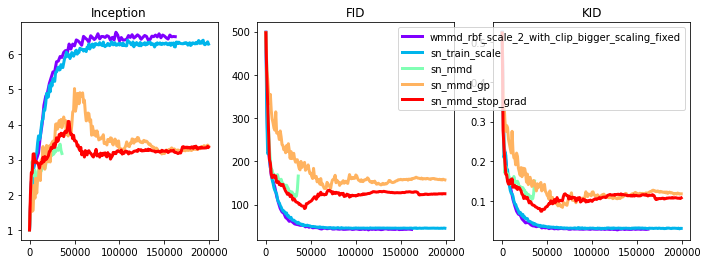

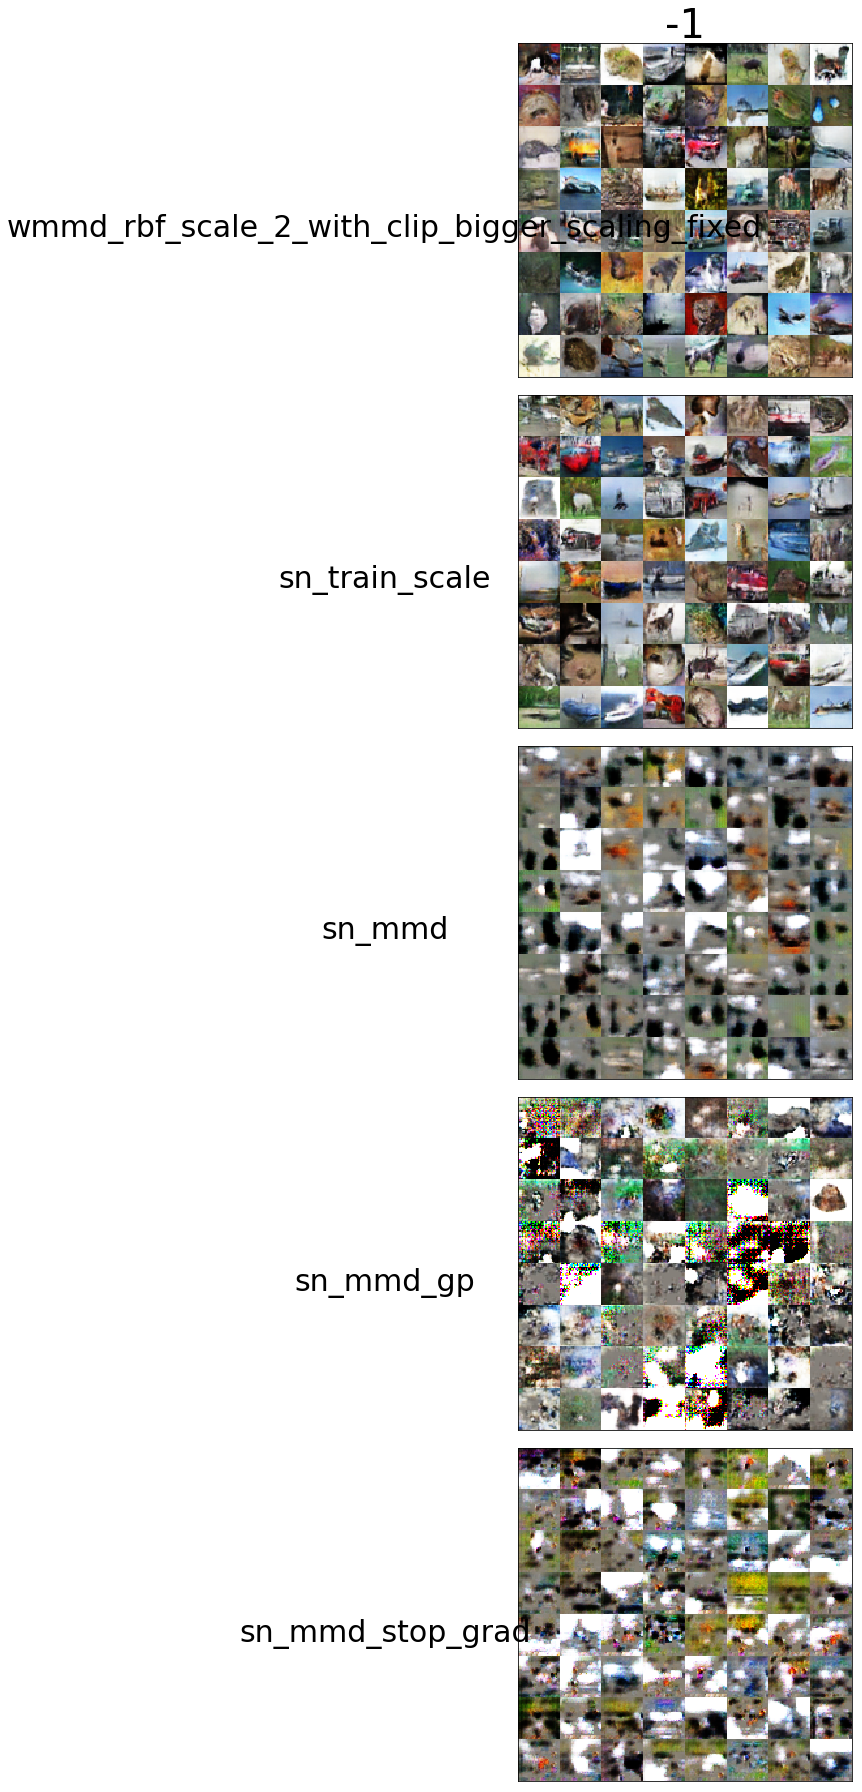

In [40]:
resdir = 'sample_mmd/cifar10'
_, df_exp_list = get_paths(resdir)
    
exp_ind = [16,18,19,20]
legends = ['rbf_2', 'rbf_4', 'rbf_6', 'rbf_8']
exp_ind = [16,23, 25,26,27]
#exp_ind = [16,21,22]
#exp_ind = [16, 35,36]
legends = None
    
iters = [-1]
start = 60000
N_max = 200000
ylims = [[0.0, 0.00015],[0.0, 0.12],[0.0, 0.12]]
ylims=None
display(df_exp_list)
f, ax, df = compute_scores(resdir, exp_ind, legends = legends,N_max= N_max,ylims = ylims, kid_only  = False, decay = False)
plt.legend(loc = 'best')
#exp_ind = [-1]
#legends = ['rbf_2']    
plot_samples(resdir,exp_ind, iters = iters, legends  = legends, y_size = 25, x_size = 25)
display(df)

exp
0            wmmd_rbf_simultaneous_update
1                      wmmd_rbf_decay_KID
2                          wmmd_rbf_dim_2
3                          wmmd_rbf_no_BN
4         wmmd_rbf_resnet_decay_MMD_dim_2
5                  swgan_resnet_decay_MMD
6    debug_higer_resolution_no_schedule_2
7         wmmd_rbf_resnet_decay_MMD_dim_1
8                wmmd_rbf_smaller_scaling
9         wmmd_rbf_smaller_scaling_resnet
10                         resnet_scale_1
11  wmmd_rbf_resnet_slow_schedule_scale_1
12                         bigger_scale_2
13                         bigger_scale_1
14                         resnet_scale_2
15                         bigger_scale_4
16                wmmd_rbf_resnet_scale_4
17                       wmmd_rbf_scale_4
18     debug_higer_resolution_no_schedule
19                         debug_gradient
20                       wmmd_rbf_scale_8
21                    wmmd_rq_dot_scale_2
22                            swgan_score
23            wmmd_rbf_resnet_scale_2_l2p
24                wmmd_rbf_resnet_scale_8
25         wmmd_rbf_resnet_scale_2_manual
26                  wmmd_rbf_TTSU_scale_2
27                  sn_train_scale_resnet
28                             resnet_160
29                resnet_160_fare_compare

FID   Inception            KID   method
res_128  12.531(0.03)  2.89(0.04)  0.0071(0.001)  res_128
res_160   13.38(0.06)  2.91(0.04)  0.0068(0.001)  res_160

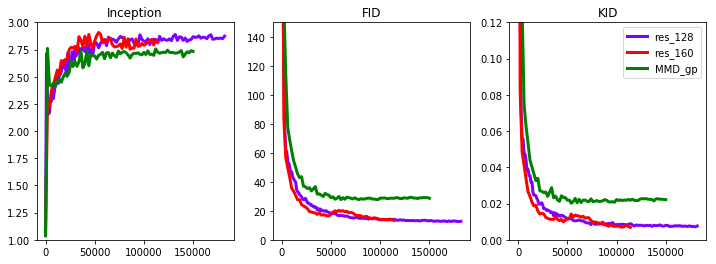

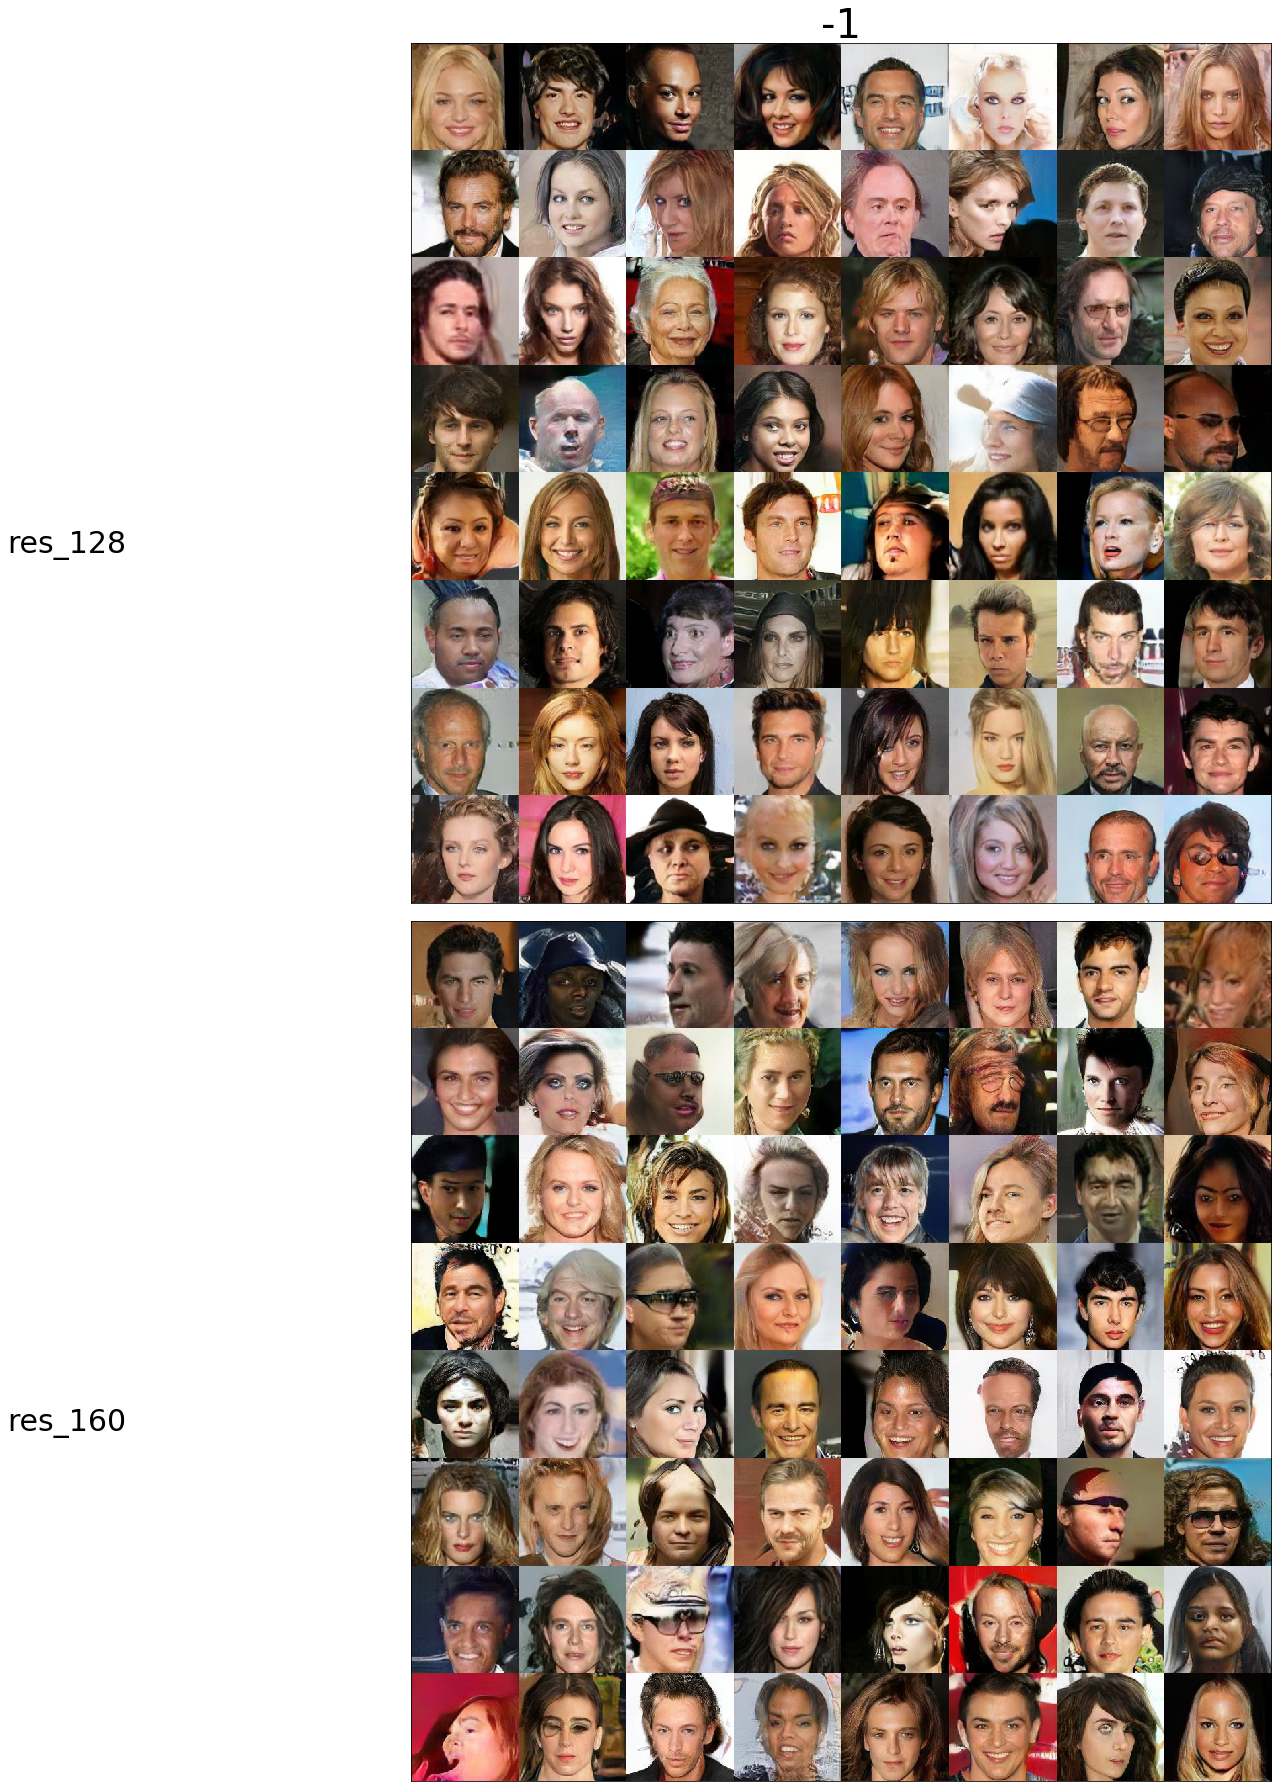

In [38]:
resdir = 'sample_mmd/celebA'
_, df_exp_list = get_paths(resdir)
    
exp_ind = [16,18,19,20]
exp_ind = [27,29]
legends = ['res_128', 'res_160']
    
iters = [-1]
start = 60000
N_max = 250000
ylims = [[1.0, 3.],[0.0, 150],[0.0, 0.12]]
#ylims=None
display(df_exp_list)
f, ax, df = compute_scores(resdir, exp_ind, legends = legends,N_max= N_max,ylims = ylims, kid_only  = False, decay = False)
plot_scores_from_file(ax, fname,N_max = 200000, N_min = 0)
plt.legend(loc = 'best')
#exp_ind = [-1]
#legends = ['rbf_2']    
plot_samples(resdir,exp_ind, iters = iters, legends  = legends, y_size = 25, x_size = 25)
display(df)